<a href="https://colab.research.google.com/github/virbickt/default-risk-prediction/blob/main/modeling_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bayesian Optimization

### Preparing data for the model

In [ ]:
INCLUSIVE_train = pd.read_csv("/content/drive/MyDrive/341/ALL_INCLUDED_train.csv")
INCLUSIVE_test = pd.read_csv("/content/drive/MyDrive/341/ALL_INCLUDED_test.csv")
WORKING_y = pd.read_csv("/content/drive/MyDrive/341/WORKING_y.csv")
WORKING_y = WORKING_y.iloc[:, 1]

In [ ]:
INCLUSIVE_train.shape, INCLUSIVE_test.shape

((307511, 524), (48744, 524))

In [ ]:
def lgbm_evaluation(
    num_leaves,
    max_depth,
    min_split_gain,
    min_child_weight,
    min_child_samples,
    reg_alpha,
    reg_lambda,
):
    """
    Objective function for Bayesian Optimization of LightGBM's Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.
    """

    params = {
        "objective": "binary",
        "boosting_type": "gbdt",
        "learning_rate": 0.005,
        "n_estimators": 10000,
        "n_jobs": -1,
        "num_leaves": int(round(num_leaves)),
        "max_depth": int(round(max_depth)),
        "min_split_gain": min_split_gain,
        "min_child_weight": min_child_weight,
        "min_child_samples": int(round(min_child_samples)),
        "reg_alpha": reg_alpha,
        "reg_lambda": reg_lambda,
        "verbosity": -1,
        "seed": 13,
    }
    stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=14)

    cv_preds = np.zeros(INCLUSIVE_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(INCLUSIVE_train, WORKING_y):

        x_tr = INCLUSIVE_train.iloc[train_indices]
        y_tr = WORKING_y.iloc[train_indices]
        x_cv = INCLUSIVE_train.iloc[cv_indices]
        y_cv = WORKING_y.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(
            x_tr,
            y_tr,
            eval_set=[(x_cv, y_cv)],
            eval_metric="auc",
            verbose=False,
            early_stopping_rounds=200,
        )

        cv_preds[cv_indices] = lgbm_clf.predict_proba(
            x_cv, num_iteration=lgbm_clf.best_iteration_
        )[:, 1]

    return roc_auc_score(WORKING_y, cv_preds)

In [ ]:
bopt_lgbm = BayesianOptimization(
    lgbm_evaluation,
    {
        "num_leaves": (25, 50),
        "max_depth": (4, 11),
        "min_split_gain": (0, 0.1),
        "min_child_weight": (5, 80),
        "min_child_samples": (5, 80),
        "reg_alpha": (0.001, 0.3),
        "reg_lambda": (0.001, 0.3),
    },
    random_state=13,
)

bayesian_optimization = bopt_lgbm.maximize(n_iter=6, init_points=4)

|   iter    |  target   | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.7894   |  9.444    |  22.82    |  66.82    |  0.09657  |  49.32    |  0.1366   |  0.1831   |
|  2        |  0.7898   |  9.429    |  53.12    |  59.15    |  0.003504 |  32.46    |  0.0185   |  0.2573   |
|  3        |  0.7894   |  6.61     |  55.99    |  24.22    |  0.03476  |  25.24    |  0.1081   |  0.2848   |
|  4        |  0.79     |  5.525    |  28.95    |  73.83    |  0.00319  |  26.63    |  0.1893   |  0.2623   |
|  5        |  0.7901   |  7.113    |  29.27    |  73.48    |  0.07552  |  27.37    |  0.03598  |  0.01474  |
|  6        |  0.79     |  9.297    |  40.04    |  72.68    |  0.03172  |  26.6     |  0.1243   |  0.151    |
|  7        |  0.7899   |  10.08    |  29.13    |  61.34    |  0.04579  |  25.1     |  0.03524  |  0.247    |
|  8      

In [ ]:
# extracting the best parameters
target_values = []

for result in bopt_lgbm.res:
    target_values.append(result["target"])
    if result["target"] == max(target_values):
        best_params = result["params"]

print("Best Hyperparameters obtained are:\n")
print(best_params)

Best Hyperparameters obtained are:

{'max_depth': 9.973180463727859, 'min_child_samples': 11.961908098565193, 'min_child_weight': 76.5825344394195, 'min_split_gain': 0.03789596767469622, 'num_leaves': 26.423589741722555, 'reg_alpha': 0.2325768129153647, 'reg_lambda': 0.1906525279747142}


In [ ]:
params = {
    "learning_rate": 0.01,
    "n_estimators": 4750,
    "n_jobs": -1,
    "objective": "binary",
    "num_leaves": 39,
    "max_depth": 10,
    "boosting_type": "gbdt",
    "min_split_gain": 0.030820727751758883,
    "min_child_weight": 30.074868967458226,
    "min_child_samples": 31,
    "reg_alpha": 0.15663020002553255,
    "reg_lambda": 0.22503178038757748,
    "metric": "auc",
    "seed": RANDOM_STATE,
    "feature_fraction": 0.1,
    "verbose": 0
}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(INCLUSIVE_train, WORKING_y, test_size=0.25, random_state=RANDOM_STATE)

In [ ]:
training_dataset = lgb.Dataset(X_train, label=y_train)
testing_dataset = lgb.Dataset(X_test, label=y_test)

clf = lgb.train(
    params,
    training_dataset,
    valid_sets=[training_dataset, testing_dataset],
    verbose_eval=500,
)

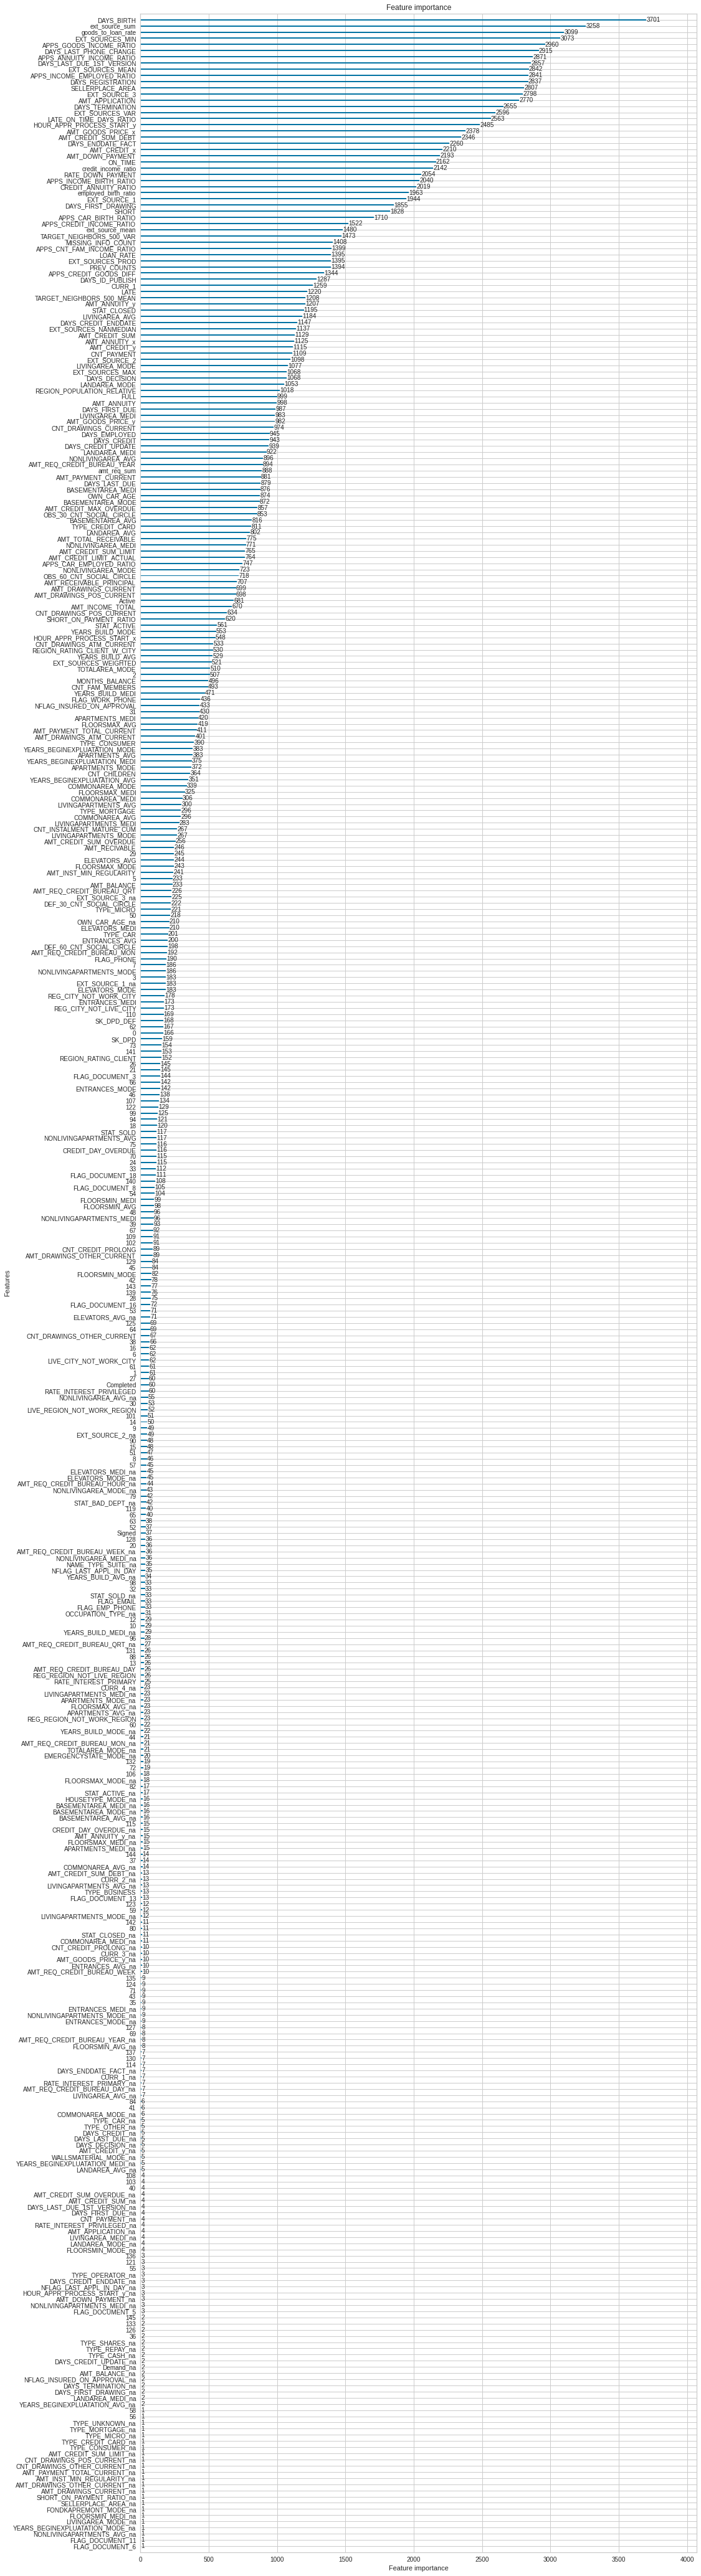

In [ ]:
plot_importance(clf, figsize=(16, 75));

In [ ]:
y_proba = clf.predict(INCLUSIVE_test)
to_csv(y_proba, "results_24")

       SK_ID_CURR    TARGET
0          100001  0.025795
1          100005  0.114376
2          100013  0.016073
3          100028  0.027166
4          100038  0.127018
...           ...       ...
48739      456221  0.087452
48740      456222  0.083738
48741      456223  0.009222
48742      456224  0.021957
48743      456250  0.270181

[48744 rows x 2 columns]


In [ ]:
print('Private leaderboard score on Kaggle: 0.78448')

Private leaderboard score on Kaggle: 0.78448
